In [32]:
import pandas as pd
from nilearn.plotting import plot_design_matrix
from nilearn.image import load_img
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from scipy.spatial import distance
from scipy.io import loadmat

In [14]:
def load_data(first_lvl_dir, contrast):
    contrast_dir = os.path.join(first_lvl_dir, contrast)
    nii_files = glob.glob(os.path.join(contrast_dir, "*.nii"))
    # sort to have consistent order
    nii_files = sorted(nii_files)
    imgs = [load_img(f) for f in nii_files]
    return imgs, nii_files

# Loading masks

In [3]:
mask_dir = '/mnt/data/learning-habits/masks/MNI152NLin2009cAsym'
mask_files = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir)]

In [4]:
mask_files

['/mnt/data/learning-habits/masks/MNI152NLin2009cAsym/parietal_AAL_MNI152NLin2009cAsym.nii',
 '/mnt/data/learning-habits/masks/MNI152NLin2009cAsym/habit_Guida2022_MNI152NLin2009cAsym.nii',
 '/mnt/data/learning-habits/masks/MNI152NLin2009cAsym/striatum_bartra2013_MNI152NLin2009cAsym.nii',
 '/mnt/data/learning-habits/masks/MNI152NLin2009cAsym/vmpfc_bartra2013_MNI152NLin2009cAsym.nii',
 '/mnt/data/learning-habits/masks/MNI152NLin2009cAsym/motor_HMAT_MNI152NLin2009cAsym.nii']

In [15]:
# Load masks as nilearn Nifti1Masker objects for ROI extraction
from nilearn.maskers import NiftiMasker
masks = {}
for mask_file in mask_files:
    roi_name = (os.path.basename(mask_file)).split('_')[0]
    mask_img = load_img(mask_file)
    masker = NiftiMasker(mask_img=mask_img)
    masks[roi_name] = masker

# Fit all maskers once
for masker in masks.values():
    masker.fit()

In [16]:
masks.pop('parietal');
masks.pop('motor');

# GLM2 - all runs combined

In [17]:
#first_lvl_dir = "/home/ubuntu/data/learning-habits/spm_format_noSDC/outputs/glm2_all_runs_scrubbed_2025-12-11-12-44"
first_lvl_dir = "/home/ubuntu/data/learning-habits/spm_outputs_noSDC//glm2_all_runs_scrubbed_2025-12-11-12-44"

In [18]:
os.listdir(first_lvl_dir)

['contrast-05_second_stimxqval',
 'contrast-01_first_stim',
 'contrast-12_hval_diff',
 'second-lvl',
 'contrast-08_purple_frame',
 'contrast_list_order_allruns.txt',
 'contrast-09_qval_sum',
 'contrast-10_hval_sum',
 'contrast-11_qval_diff',
 'contrast-06_second_stimxhval',
 'contrasts_manifest.tsv',
 'contrast-04_second_stim',
 'contrast-07_response',
 'contrast-02_first_stimxqval',
 'contrast-03_first_stimxhval']

In [19]:
#spm_path = os.path.join(first_lvl_dir,'sub-01','SPM.mat')
#SPM = loadmat(spm_path, squeeze_me=True, struct_as_record=False)['SPM']
#SPM.xX.name

In [20]:
contrasts = ['contrast-02_first_stimxqval',
             'contrast-03_first_stimxhval',
             'contrast-05_second_stimxqval',
             'contrast-06_second_stimxhval']

data = {}
for contrast in contrasts:
    maps, nii_files = load_data(first_lvl_dir, contrast)
    data[contrast] = {'maps': maps, 'nii_files': nii_files}

In [35]:
# Path to save/load the DataFrame
plot_df_path = '../cache/glm2_all_runs_firstlvl_betas.csv'

if os.path.exists(plot_df_path):
    print(f"Loading cached plot_df from {plot_df_path}")
    plot_df = pd.read_csv(plot_df_path, index_col=[0,1,2])
else:
    # Extract mean beta values for each ROI and plot as bar plots, using in-memory images
    results = []
    for contrast in contrasts:
        imgs = data[contrast]['maps']  # list of Nifti1Image objects
        nii_files = data[contrast]['nii_files']
        for i, img in enumerate(imgs):
            base = os.path.basename(nii_files[i])
            m = re.search(r'sub-\d+', base)
            subj = m.group(0) if m else base
            for roi, masker in masks.items():
                X = masker.transform([img])  # shape (1, n_voxels)
                mean_val = np.asarray(X).mean()
                results.append({
                    'subject': subj,
                    'roi': roi,
                    'contrast': contrast,
                    'mean_beta': mean_val
                })
    plot_df = pd.DataFrame(results)
    plot_df.set_index(['contrast', 'roi','subject'], inplace=True)
    plot_df.to_csv(plot_df_path)
    print(f"Saved plot_df to {plot_df_path}")

plot_df.head()

Loading cached plot_df from ../cache/glm2_all_runs_firstlvl_betas.csv


mean_beta
contrast                    roi      subject           
contrast-02_first_stimxqval habit    sub-01    0.490942
                            striatum sub-01    0.163740
                            vmpfc    sub-01   -2.675879
                            habit    sub-02   -0.178035
                            striatum sub-02   -0.315985

In [47]:
plot_df.head()

subject  mean_beta
contrast                    roi                        
contrast-02_first_stimxqval habit     sub-01   0.490942
                            striatum  sub-01   0.163740
                            vmpfc     sub-01  -2.675879
                            habit     sub-02  -0.178035
                            striatum  sub-02  -0.315985

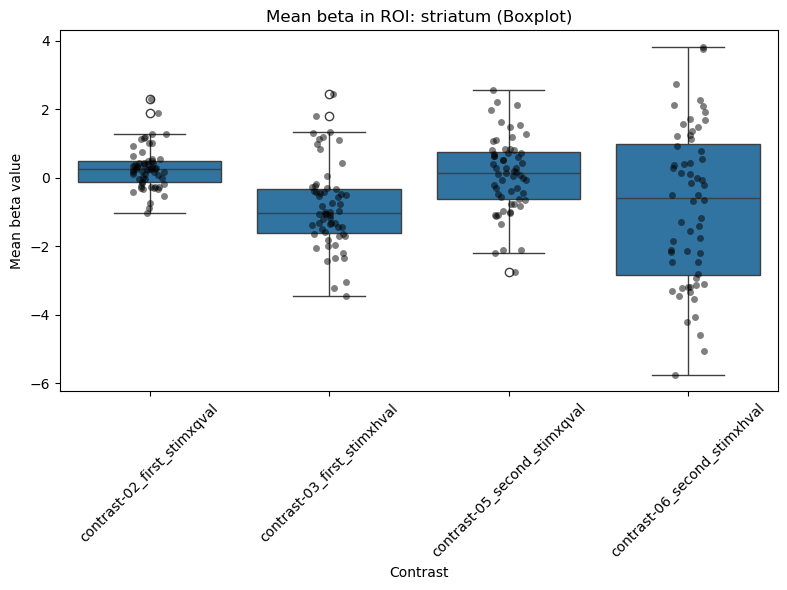

In [56]:
# Boxplot for the two first contrasts in the striatum ROI, using a flat DataFrame (no multi-index)
roi_of_interest = 'striatum'
contrasts_of_interest = contrasts[:5]

# Always work with a flat DataFrame
plot_df_flat = plot_df.reset_index() if isinstance(plot_df.index, pd.MultiIndex) else plot_df.copy()

# Filter for the desired ROI and contrasts
subset = plot_df_flat[(plot_df_flat['roi'] == roi_of_interest) & (plot_df_flat['contrast'].isin(contrasts_of_interest))]

plt.figure(figsize=(8,6))
sns.boxplot(x='contrast', y='mean_beta', data=subset)
sns.stripplot(x='contrast', y='mean_beta', data=subset, color='black', alpha=0.5, jitter=True)
#plt.axhline(0, color='gray', linewidth=1)
plt.title(f'Mean beta in ROI: {roi_of_interest} (Boxplot)')
plt.ylabel('Mean beta value')
plt.xlabel('Contrast')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# GLM chosen - all runs combined

In [57]:
first_lvl_dir = "/home/ubuntu/data/learning-habits/spm_outputs_noSDC//glm2_chosen_all_runs_scrubbed_2025-12-11-11-22"

In [58]:
os.listdir(first_lvl_dir)

['contrast-01_first_stim',
 'second-lvl',
 'contrast-05_response',
 'contrast-06_purple_frame',
 'contrast_list_order_allruns.txt',
 'contrast-02_second_stim',
 'contrast-04_second_stimxhval_chosen',
 'contrasts_manifest.tsv',
 'contrast-03_second_stimxqval_chosen']

In [ ]:
#spm_path = os.path.join(first_lvl_dir,'sub-01','SPM.mat')
#SPM = loadmat(spm_path, squeeze_me=True, struct_as_record=False)['SPM']
#SPM.xX.name

In [59]:
contrasts = ['contrast-03_second_stimxqval_chosen',
             'contrast-04_second_stimxhval_chosen',]

data = {}
for contrast in contrasts:
    maps, nii_files = load_data(first_lvl_dir, contrast)
    data[contrast] = {'maps': maps, 'nii_files': nii_files}

In [60]:
# Path to save/load the DataFrame
plot_df_path = '../cache/glm_chosen_all_runs_firstlvl_betas.csv'

if os.path.exists(plot_df_path):
    print(f"Loading cached plot_df from {plot_df_path}")
    plot_df = pd.read_csv(plot_df_path, index_col=[0,1,2])
else:
    # Extract mean beta values for each ROI and plot as bar plots, using in-memory images
    results = []
    for contrast in contrasts:
        imgs = data[contrast]['maps']  # list of Nifti1Image objects
        nii_files = data[contrast]['nii_files']
        for i, img in enumerate(imgs):
            base = os.path.basename(nii_files[i])
            m = re.search(r'sub-\d+', base)
            subj = m.group(0) if m else base
            for roi, masker in masks.items():
                X = masker.transform([img])  # shape (1, n_voxels)
                mean_val = np.asarray(X).mean()
                results.append({
                    'subject': subj,
                    'roi': roi,
                    'contrast': contrast,
                    'mean_beta': mean_val
                })
    plot_df = pd.DataFrame(results)
    plot_df.set_index(['contrast', 'roi','subject'], inplace=True)
    plot_df.to_csv(plot_df_path)
    print(f"Saved plot_df to {plot_df_path}")

plot_df.head()

Saved plot_df to ../cache/glm_chosen_all_runs_firstlvl_betas.csv


mean_beta
contrast                            roi      subject           
contrast-03_second_stimxqval_chosen habit    sub-01    0.200860
                                    striatum sub-01    0.429869
                                    vmpfc    sub-01   -0.897976
                                    habit    sub-02    0.111191
                                    striatum sub-02    0.701198

In [61]:
plot_df.head()

mean_beta
contrast                            roi      subject           
contrast-03_second_stimxqval_chosen habit    sub-01    0.200860
                                    striatum sub-01    0.429869
                                    vmpfc    sub-01   -0.897976
                                    habit    sub-02    0.111191
                                    striatum sub-02    0.701198

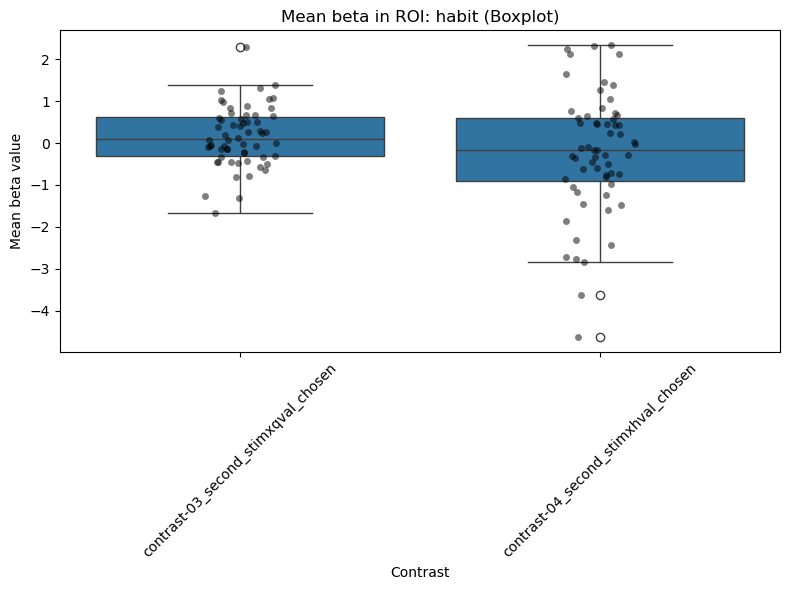

In [63]:
# Boxplot for the two first contrasts in the striatum ROI, using a flat DataFrame (no multi-index)
roi_of_interest = 'habit'
contrasts_of_interest = contrasts

# Always work with a flat DataFrame
plot_df_flat = plot_df.reset_index() if isinstance(plot_df.index, pd.MultiIndex) else plot_df.copy()

# Filter for the desired ROI and contrasts
subset = plot_df_flat[(plot_df_flat['roi'] == roi_of_interest) & (plot_df_flat['contrast'].isin(contrasts_of_interest))]

plt.figure(figsize=(8,6))
sns.boxplot(x='contrast', y='mean_beta', data=subset)
sns.stripplot(x='contrast', y='mean_beta', data=subset, color='black', alpha=0.5, jitter=True)
#plt.axhline(0, color='gray', linewidth=1)
plt.title(f'Mean beta in ROI: {roi_of_interest} (Boxplot)')
plt.ylabel('Mean beta value')
plt.xlabel('Contrast')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()